# Generative Adversarial Learning for Intelligent 5G Interference Mitigation

In this notebook, we implement a generative adversarial network (GAN) for use in 5G wireless interference mitigation.

In [80]:
# %matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from typing import Literal

sns.set() # Use seaborn themes.

In [81]:
# Here define some root paths for saving content.
roots = dict(
    dataset = Path('./dataset/'),
    images = Path('./images/'),
)
for k,r in roots.items(): # Create directories if they do not already exist.
    if not r.exists():
        r.mkdir(exist_ok=True)

## Types of Adversarial Attacks

1. Attack on 5G spectrum sharing ([section IV-A](https://arxiv.org/pdf/2101.02656.pdf))
    * Discriminator learns whether channel is idle or busy (based on [RSSIs](https://en.wikipedia.org/wiki/Received_signal_strength_indication))
    * Generator learns to transmit when channel is considered idle to make the channel be considered busy
1. Attack on signal authentication in network slicing ([section IV-B](https://arxiv.org/pdf/2101.02656.pdf))
    * The network provides services to authenticated user equipment (UE, i.e., cellphones)
    * Discriminator is trained to identify UEs for auth (trained on signal I/Q data, both power and phase)
    * Generator produces signals with I/Q that match those of authenticated UEs by monitoring the wireless environment

## GAN Model Definitions

In [82]:
def make_rnn(
    input_shape: tuple,
    n_layers: int,
    hidden_units: int|list[int], # If list, length must be the same as number of layers
    output_units: int, # Number of units in final dense layer
    layer_type: Literal['lstm', 'gru'],
    activation: str = 'softmax',
    name: str = None,
    ) -> keras.Model:
    assert layer_type in ('lstm', 'gru'), 'unsupported layer type'

    # Process hidden layers.
    if isinstance(hidden_units, (tuple, list)):
        assert len(hidden_units) == n_layers
    elif isinstance(hidden_units, int):
        hidden_units = [hidden_units]*n_layers

    # List of layers.
    layers = [
        keras.Input(shape=input_shape),
    ]

    # LSTM.
    if layer_type == 'lstm':
        for i in range(n_layers):
            layers.append(keras.layers.LSTM(
                units=hidden_units[i],
                return_sequences=True,
                name=f'LSTM_{i}',
                ))
    # GRU.
    elif layer_type == 'gru':
        for i in range(n_layers):
            layers.append(keras.layers.GRU(
                units=hidden_units[i],
                return_sequences=True,
                name=f'GRU_{i}',
                ))

    # Classifier.
    layers.append(keras.layers.Dense(
        units=output_units,
        activation=activation,
        name='classifier',
        ))

    # Build model and return.
    return keras.Sequential(layers=layers, name=name)

In [83]:
def Discriminator(
    *args,
    model_type: Literal['rnn'] = 'rnn',
    **kwargs,
    ) -> keras.Model:
    assert model_type in ('rnn',), f'unsupported model type {repr(model_type)}'

    # Build model and return.
    if model_type == 'rnn':
        return make_rnn(
            *args,
            name='discriminator', # Default name, but can be overridden.
            output_units=1,
            activation='sigmoid',
            **kwargs,
        )

In [84]:
def Generator(
    *args,
    model_type: Literal['rnn'] = 'rnn',
    **kwargs,
    ) -> keras.Model:
    assert model_type in ('rnn',), f'unsupported model type {repr(model_type)}'

    # Build model and return.
    if model_type == 'rnn':
        return make_rnn(
            *args,
            name='generator', # Default name, but can be overridden.
            activation='sigmoid',
            **kwargs,
        )

## Model Training

Because we are working with two models, a `generator` and `discriminator`, that rely on the outputs of the other, we must treat their training and optimization as coupled. To do this, we define a custom training step function that computes a separate gradient for each model (under the hood using the TensorFlow `GradientTape()`).

In [85]:
# https://www.tensorflow.org/tutorials/generative/dcgan
# https://medium.com/dive-into-ml-ai/customization-of-model-fit-to-write-a-combined-discriminator-generator-gan-trainer-in-keras-524bce10cf66
# https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#wrapping_up_an_end-to-end_gan_example


class GAN(keras.Model):
    """Generative Adversarial Network (GAN)

    This GAN allows custom discriminator and generator models to be used.
    """
    def __init__(self,
        discriminator: keras.Model,
        generator: keras.Model,
        latent_shape: list,
        ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_shape = latent_shape

    def compile(self,
        d_optimizer,
        g_optimizer,
        d_loss_fn,
        g_loss_fn,
        ):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, x: tf.Tensor):
        if isinstance(x, tuple):
            x = x[0]
        batch_size = tf.shape(x)[0]

        # Sample random points in latent space to generate features.
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

        # Generate "fake" features.
        x_fake = self.generator(random_latent_vectors)

        # Combine "fake" features with the "real" ones.
        x_all = tf.concat([x_fake, x], axis=0)

        # Assemble labels for "fake" and "real" features.
        labels = tf.concat([
            tf.ones((batch_size, *self.latent_shape[:-1], 1)), # Fake
            tf.zeros((batch_size, *self.latent_shape[:-1], 1)), # Real
        ], axis=0)

        # Add random noise to labels.
        labels *= 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator.
        with tf.GradientTape() as d_tape:
            y_all = self.discriminator(x_all)
            d_loss = self.d_loss_fn(labels, y_all)
        d_grad = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(d_grad, self.discriminator.trainable_weights)
        )

        # (again) Sample random points in latent space to generate features.
        # We do this again so that we use different random vectors from the ones we used when training the discriminator.
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_shape))

        # Assemble labels to mislead discriminator into thinking all are "real" features.
        labels = tf.zeros((batch_size, *self.latent_shape[:-1], 1)) # Real

        # Train the generator.
        with tf.GradientTape() as g_tape:
            y_fake = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.g_loss_fn(labels, y_fake)
        g_grad = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(g_grad, self.generator.trainable_weights)
        )

        # Return discriminator and generator losses.
        return {"d_loss": d_loss, "g_loss": g_loss}

## Data Loading and Preprocessing

In this work we use raw signal data, which takes the form of complex numbers (called "IQ"). However, a currently limitation of TensorFlow models is that they cannot accept complex data as input. The reason for this is because values must be *ordered* for their gradient to exist, which is true for real numbers, and false for complex numbers. Therefore, we convert the IQ data into `magnitude` and `phase` features, which are real-valued elements.

In [86]:
def load_data(fname: str) -> tuple[np.ndarray, dict]:
    # Load numpy NPZ file.
    data = np.load(f"{fname}.npz")

    # Load parameter from JSON file.
    with open(f"{fname}.json", 'r') as f:
        params = json.load(f)
    return data, params

In [87]:
def normalize(x: np.ndarray) -> np.ndarray:
    """Normalize input to range [0,1]"""
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min)/(x_max - x_min)


def preprocess(x: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Preprocess complex input features.

    Steps are:
        1. Convert complex numbers to magnitude/phase components.
        2. Scale magnitude/phase to range [0,1].
    """

    # Convert complex to magnitude/phase.
    x_mag = np.abs(x)
    x_phi = np.angle(x, deg=False) # Radians.

    # Scale to range [0,1].
    x_mag_norm = normalize(x_mag)
    x_phi_norm = normalize(x_phi)

    return x_mag_norm, x_phi_norm


In [88]:
def sliding_windows(x: np.ndarray, window_len: int) -> np.ndarray:
    return np.lib.stride_tricks.sliding_window_view(x=x, window_shape=window_len)

In [89]:
window_len = 24 # Length of input data time windows.
feat_len = 2 # Number of input feature dimensions.
batch_size = 64

data, params = load_data(roots['dataset']/"16-qam")
x = sliding_windows(data['x'], window_len=window_len)
x_mag, x_phi = preprocess(x)
x_all = np.dstack([x_mag, x_phi]) # Stack along new dimension.
x_all = x_all.astype(dtype=np.float32)
dataset = tf.data.Dataset.from_tensor_slices(x_all) # Create dataset.
dataset = dataset.batch(batch_size=batch_size)

## Training

In [90]:
m_dis = Discriminator(
    model_type='rnn',
    input_shape=(window_len, feat_len),
    n_layers=5,
    hidden_units=256,
    layer_type='gru',
)

latent_shape = (window_len, feat_len*3) # Shape of random vectors used in generation.
m_gen = Generator(
    model_type='rnn',
    input_shape=latent_shape,
    n_layers=5,
    hidden_units=256,
    output_units=feat_len, # Must match number of input features in discriminator.
    layer_type='gru',
)

model = GAN(
    discriminator=m_dis,
    generator=m_gen,
    latent_shape=latent_shape,
)
model.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    d_loss_fn=keras.losses.BinaryCrossentropy(from_logits=False), # Each class has range [0,1], sigmoid was used so no logits.
    g_loss_fn=keras.losses.BinaryCrossentropy(from_logits=False), # Each class has range [0,1], sigmoid was used so no logits.
)

model.fit(
    dataset.take(5),
    epochs=1,
)

5/5 [==============================] - 24s 661ms/step - d_loss: 0.3375 - g_loss: 0.2000


## Data Visualization Examples

In [ ]:
def plot(
    n: np.ndarray,
    s: np.ndarray,
    x: np.ndarray,
    fs: float,
    baud: int,
    ):

    plt.figure()

    fig, axd = plt.subplot_mosaic("A;B;C", figsize=(7,12))
    pkey = 'A'
    axd[pkey].plot(n, s, marker='o', markevery=int(fs/baud))
    axd[pkey].set_title('Data')

    pkey = 'B'
    axd[pkey].plot(n, np.real(x), label='real')
    axd[pkey].plot(n, np.imag(x), label='imag')
    axd[pkey].set_title('Signal')
    axd[pkey].legend()

    pkey = 'C'
    axd[pkey].plot(np.real(x.round(10)), np.imag(x.round(10)), '.')
    axd[pkey].set_title('Constellation')
    axd[pkey].grid(True)

    return fig

<Figure size 640x480 with 0 Axes>

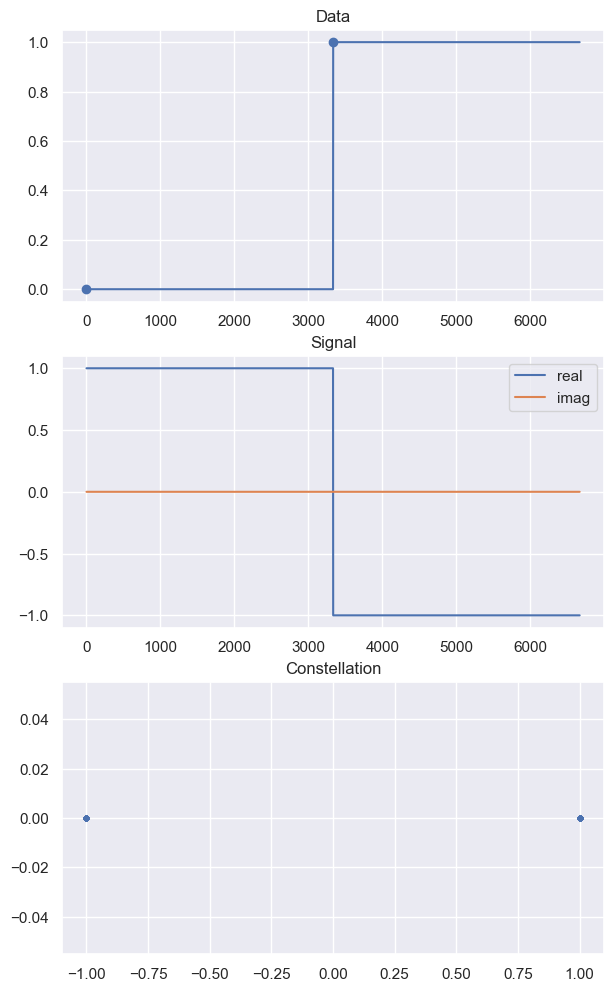

In [ ]:
data, params = load_data(roots['dataset']/"bpsk")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

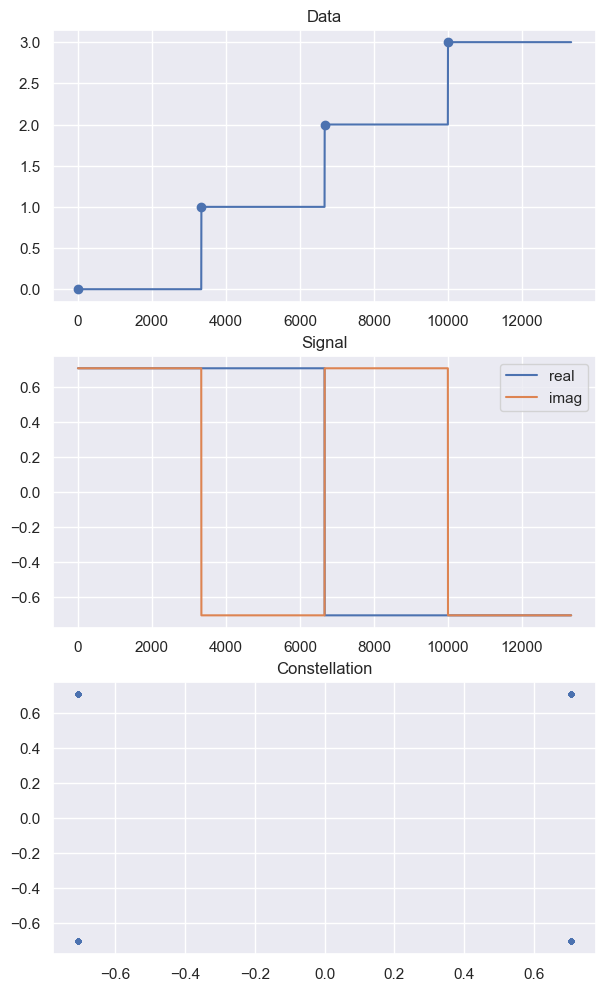

In [ ]:
data, params = load_data(roots['dataset']/"qpsk")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

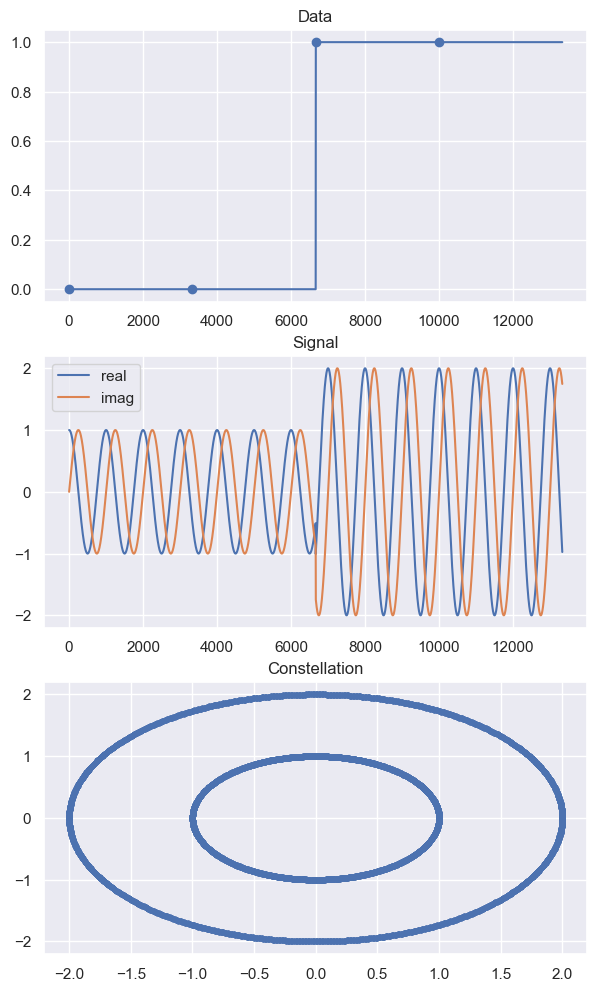

In [ ]:
data, params = load_data(roots['dataset']/"2-ask")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

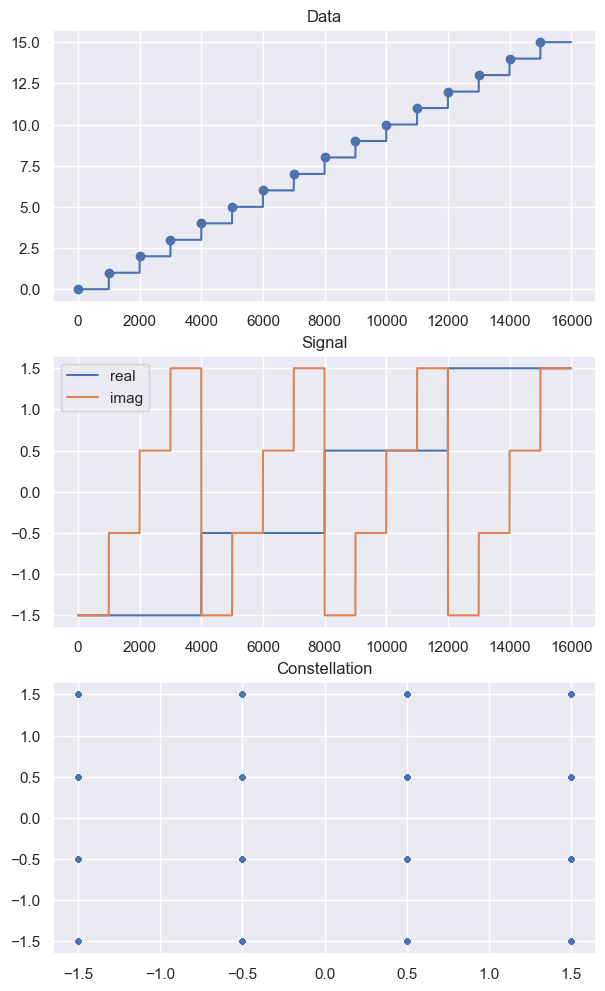

In [ ]:
data, params = load_data(roots['dataset']/"16-qam")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

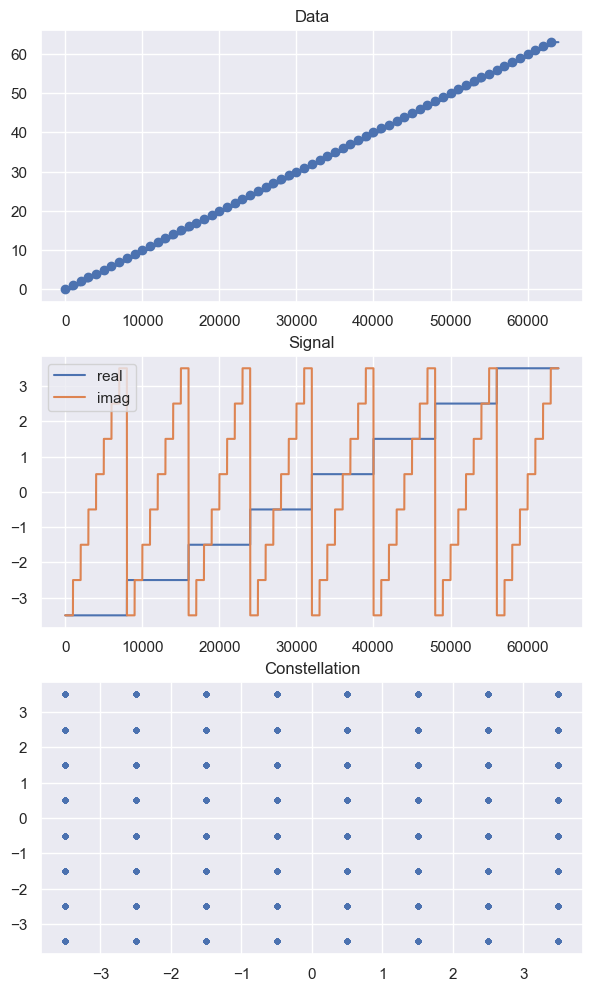

In [ ]:
data, params = load_data(roots['dataset']/"64-qam")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 640x480 with 0 Axes>

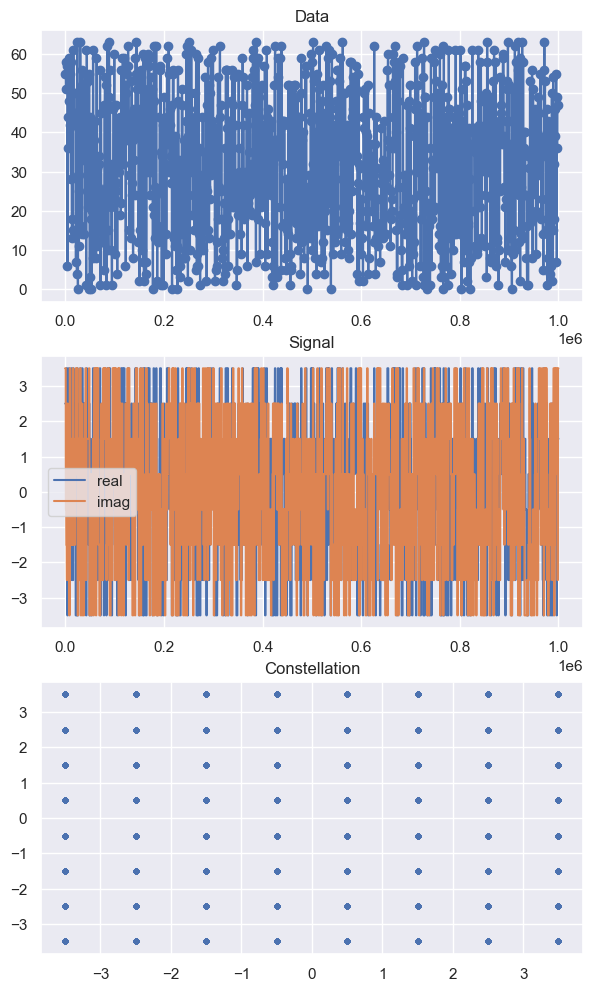

In [ ]:
data, params = load_data(roots['dataset']/"64-qam-long")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)